In [1]:
import numpy as np
from numpy import exp, pi, cos, sqrt, arcsin
import matplotlib.pyplot as plt
from control import tf
# from matplotlib.widgets import Slider, Button, RadioButtons

In [4]:
def test(a, b):
    return (a, b)

well = {"a": 1, "b": "a"}
test(**well)

(1, 'a')

In [79]:
c = 3e8

class Fabry:
    def __init__(self, L0, radius, lamda=1064, r=(0.8, 1), t=(0.2, 0), m=0.1, refrac_index=1):
        '''
        L0: float
            desired length of the Fabry-Perot Cavity
        radius: array_like
            radius of curvature of the input mirror and output mirror respectively.
        lamda: float
            carrier wavelength of the laser, in nm.
        r: array_like
            reflection coefficient of the input mirror and output mirror respectively, range:0 to 1.
        t: array_like
            transmission coefficient of the input mirror and output mirror respectively, range:0 to 1.
        m: float
            phase modulation index of the laser.
        refrac_index: float
            refractive index of the space within the cavity between two mirrors, >= 1.
        '''
        r = np.array(r)
        t = np.array(t)
        radius = np.array(radius)
        if np.any(r**2 + t**2 > 1.) :
            raise ValueError("The square sum of relection coef"
                             "and transmission coef should not greater than 1.")
        self.mirror_loss = 1 - r**2 + t**2
        self.target_length = self.cavity_length = L0
        self.reflection_coef = r
        self.transmssion_coef = t
        self.input_wavelength = lamda*1e-9 # nm
        self.modulation_index = m
    
    
    class Mirror:
        def __init__(self, r, t, m):
            self.reflection_coef = r
            self.transmssion_coef = t
            self.coup_matrix = np.array([[],
                                         []])
    
    
    mirror1 = Mirror(self.reflection_coef[0], self.transmssion_coef[0], self.modulation_index)
    mirror2 = Mirror(self.reflection_coef[1], self.transmssion_coef[1], self.modulation_index)
    
    class Space:
        def __init__(self):
            self.length = super().cavity_length
            self.refrac_index = super().refrac_index
            self.coup_matrix = np.array([[],
                                         []])
    
    space = Space()
    
    def cal(self, freq_offset, E_in, tuning=True, modulation=True):
        r1, r2 = self.reflection_coef
        t1, t2 = self.transmssion_coef
        L = self.cavity_length 
        
        a0 = E_in
        k = 2*pi/self.input_wavelength + 2*pi*freq_offset/c
        a2 =  -t1*t2*exp(-1j*k*L)/(1 - r1*r2*exp(-2j*k*L))
        a4 = (r1 -r2*(r1**2 + t1**2)*exp(-2j*k*L))/(1 - r1*r2*exp(-2j*k*L))
        
        self.trans_power = np.abs(a2)**2
        self.reflect_power = np.abs(a4)**2
        self.circ_power = (np.abs(a0)**2 
                           * t1**2
                           /(1 + r1**2*r2**2 - 2*r1*r2*cos(2*k*L)))
    
    def update(delta_L):
        self.cavity_length += delta_L
        self.space_matrix = np.array([[exp(-1j*k*self.cavity_length), 0],
                                      [0, exp(-1j*k*self.cavity_length)]])
        

In [49]:
k = 2*pi/1064e-9 + 2*pi*f/c
1e8*pi/k

array([53.20000001, 53.20000001, 53.20000001, ..., 53.19999987,
       53.19999987, 53.19999987])

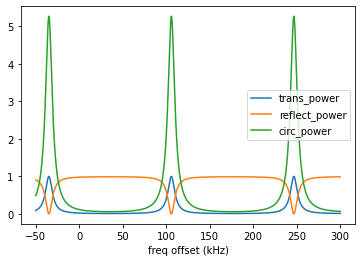

In [78]:
if __name__ == '__main__':
    r = np.array([0.9, 0.9])
    t = sqrt(1 - r**2)
    f = np.linspace(-50, 300, 20000) * 1e3
    fabry = Fabry(1064, 1, r=r, t=t)
    fabry.cal(0, 1, f)
    names = ["trans_power", "reflect_power", "circ_power"]
    for i, name in zip([fabry.trans_power, fabry.reflect_power, fabry.circ_power],
                    names):
        plt.plot(f/1e3, i, label = name)
        plt.xlabel("freq offset (kHz)")
        plt.legend()